Esabo and Inverse Esabo training code:

In [ ]:
# Step 1: Install & Imports
# !pip install yfinance -q
# !pip install statsmodels -q
# !pip install joblib -q
# !pip install openpyxl -q

import yfinance as yf
import pandas as pd
import numpy as np
from itertools import combinations
from joblib import Parallel, delayed
import matplotlib.pyplot as plt
import warnings
import os
from tqdm.notebook import tqdm
import logging

# --- Setup Professional Logging ---
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s',
    datefmt='%Y-%m-%d %H:%M:%S'
)

warnings.filterwarnings("ignore")

# --- Configuration ---
class Config:
    """Holds all configuration parameters for the strategy."""
    YEARS = 5
    END_DATE = pd.Timestamp.today()
    START_DATE = END_DATE - pd.DateOffset(years=YEARS)

    # Walk-Forward Parameters
    TRAIN_PERIOD_DAYS = 126
    TRADE_PERIOD_DAYS = 21
    TOP_N_PAIRS = 20

    # ESABO Signal Parameters (Relaxed)
    ROLLING_WINDOW = 30
    ROBUST_Z_THRESHOLD = 1.25  # Lowered from 1.5 to allow more signals
    MIN_SIGNAL_PCT = 0.10

    # Pair Quality Filter Weights (Adjusted)
    ESABO_WEIGHT = 0.60        # Increased to prioritize the ESABO signal
    HURST_WEIGHT = 0.20        # Decreased as it's no longer a hard filter
    STABILITY_WEIGHT = 0.20
    CORRELATION_THRESHOLD = 0.3 # Lowered from 0.4 to allow more candidates

    # File Paths
    HOLDINGS_FILE = "/content/holdings-daily-us-en-spy.xlsx"
    OUTPUT_DIR = "/content/esabo_strategy_output"
    ESABO_PAIRS_FILE = os.path.join(OUTPUT_DIR, "esabo_pairs.csv")
    INVERSE_PAIRS_FILE = os.path.join(OUTPUT_DIR, "inverse_esabo_pairs.csv")

# --- Data Loading ---
class DataLoader:
    """Handles loading and preparation of market data."""
    @staticmethod
    def load_tickers_from_file(filepath):
        """Loads only the ticker symbols from the specified Excel file."""
        df = pd.read_excel(filepath)
        if 'Ticker' not in df.columns:
            raise KeyError(f"'Ticker' column not found in {filepath}. Please check the file.")
        tickers = df['Ticker'].dropna().astype(str).str.replace('.', '-', regex=False).unique().tolist()
        return tickers

    @staticmethod
    def fetch_sector_map(tickers):
        """Fetches sector information for a list of tickers from yfinance."""
        logging.info(f"Fetching sector data for {len(tickers)} tickers from yfinance...")
        sector_map = {}
        for ticker in tqdm(tickers, desc="Fetching Sectors"):
            try:
                info = yf.Ticker(ticker).info
                sector = info.get('sector', None)
                if sector:
                    sector_map[ticker] = sector
                else:
                    logging.warning(f"No sector found for ticker: {ticker}")
            except Exception as e:
                logging.error(f"Could not fetch info for {ticker}: {e}")
        logging.info(f"Successfully fetched sector data for {len(sector_map)} tickers.")
        return sector_map

    @staticmethod
    def fetch_prices(tickers, start, end):
        df = yf.download(tickers, start=start, end=end, auto_adjust=False, progress=False)['Adj Close']
        return df.dropna(axis=1, thresh=int(0.9 * len(df)))

# --- Core Logic ---
class PairSelector:
    """
    Encapsulates the logic for finding high-quality pairs using a composite score.
    Refactored for parallel execution, robust logging, and performance optimization.
    """
    def __init__(self, config):
        self.cfg = config

    @staticmethod
    def _get_adaptive_boolean_matrices(returns, threshold, window):
        rolling_median = returns.rolling(window=window, min_periods=window//2).median()
        rolling_mad = returns.rolling(window=window, min_periods=window//2).apply(lambda x: np.median(np.abs(x - np.median(x))), raw=True)
        robust_z = (returns - rolling_median) / rolling_mad.replace(0, np.nan)
        return (robust_z > threshold), (robust_z < -threshold)

    @staticmethod
    def _esabo_metric(a, b):
        both = np.logical_and(a, b).sum()
        either = np.logical_or(a, b).sum()
        return both / either if either > 0 else 0.0

    @staticmethod
    def _hurst_exponent(series):
        if len(series) < 100: return 0.5
        lags = range(2, 100)
        try:
            tau = [np.sqrt(np.std(np.subtract(series[lag:], series[:-lag]))) for lag in lags]
            poly = np.polyfit(np.log(lags), np.log(tau), 1)
            return poly[0] * 2.0
        except (np.linalg.LinAlgError, ValueError):
            return 0.5 # Return neutral value if calculation fails

    @staticmethod
    def _process_pair(pair_data):
        """Worker function to process a single pair, returning structured status and data."""
        t1, t2, train_returns, bool_up, bool_down, cfg = pair_data

        try:
            results = []

            # --- Standard ESABO ---
            score_std = PairSelector._esabo_metric(bool_up[t1], bool_up[t2])
            if score_std > 0:
                spread = train_returns[t1] - train_returns[t2]
                hurst = PairSelector._hurst_exponent(spread.dropna())
                stability_score = 1 - np.std(spread)
                composite_score = (score_std * cfg.ESABO_WEIGHT + (1 - hurst) * cfg.HURST_WEIGHT + stability_score * cfg.STABILITY_WEIGHT)
                results.append({'type': 'standard', 't1': t1, 't2': t2, 'composite': composite_score, 'esabo': score_std, 'hurst': hurst})

            # --- Inverse ESABO (t1_up, t2_down) ---
            score_inv1 = PairSelector._esabo_metric(bool_up[t1], bool_down[t2])
            if score_inv1 > 0:
                spread = train_returns[t1] - train_returns[t2]
                hurst = PairSelector._hurst_exponent(spread.dropna())
                stability_score = 1 - np.std(spread)
                composite_score = (score_inv1 * cfg.ESABO_WEIGHT + (1 - hurst) * cfg.HURST_WEIGHT + stability_score * cfg.STABILITY_WEIGHT)
                results.append({'type': 'inverse', 't1': t1, 't2': t2, 'composite': composite_score, 'esabo': score_inv1, 'hurst': hurst})

            # --- Inverse ESABO (t2_up, t1_down) ---
            score_inv2 = PairSelector._esabo_metric(bool_up[t2], bool_down[t1])
            if score_inv2 > 0:
                spread = train_returns[t2] - train_returns[t1]
                hurst = PairSelector._hurst_exponent(spread.dropna())
                stability_score = 1 - np.std(spread)
                composite_score = (score_inv2 * cfg.ESABO_WEIGHT + (1 - hurst) * cfg.HURST_WEIGHT + stability_score * cfg.STABILITY_WEIGHT)
                results.append({'type': 'inverse', 't1': t2, 't2': t1, 'composite': composite_score, 'esabo': score_inv2, 'hurst': hurst})

            if not results:
                return {'status': 'fail_score'}

            return {'status': 'success', 'data': results}
        except Exception as e:
            return {'status': 'error', 'pair': f"{t1}-{t2}", 'error': str(e)}

    def find_best_pairs(self, train_returns, sector_map):
        cols = ['T1', 'T2', 'CompositeScore', 'ESABOScore', 'Hurst']
        esabo_df = pd.DataFrame(columns=cols)
        inverse_df = pd.DataFrame(columns=cols)

        bool_up, bool_down = self._get_adaptive_boolean_matrices(train_returns, self.cfg.ROBUST_Z_THRESHOLD, self.cfg.ROLLING_WINDOW)

        min_signals = int(len(train_returns) * self.cfg.MIN_SIGNAL_PCT)
        valid_tickers = {t for t in bool_up.columns if bool_up[t].sum() >= min_signals or bool_down[t].sum() >= min_signals}
        logging.info(f"Found {len(valid_tickers)} tickers meeting the minimum signal requirement.")

        if len(valid_tickers) < 2:
            logging.warning("Not enough valid tickers to form pairs.")
            return esabo_df, inverse_df

        valid_list = list(valid_tickers)
        corr_matrix = train_returns[valid_list].corr()

        all_pairs_to_process = []
        tickers_by_sector = {}
        for ticker in valid_tickers:
            sector = sector_map.get(ticker)
            if sector and isinstance(sector, str):
                tickers_by_sector.setdefault(sector, []).append(ticker)

        total_candidate_pairs = 0
        for tickers in tickers_by_sector.values():
            if len(tickers) >= 2:
                for t1, t2 in combinations(tickers, 2):
                    total_candidate_pairs += 1
                    if abs(corr_matrix.loc[t1, t2]) > self.cfg.CORRELATION_THRESHOLD:
                        all_pairs_to_process.append((t1, t2, train_returns, bool_up, bool_down, self.cfg))

        logging.info(f"Generated {total_candidate_pairs} initial pairs. After correlation filter (> {self.cfg.CORRELATION_THRESHOLD}), "
                     f"{len(all_pairs_to_process)} pairs remain for processing.")

        if not all_pairs_to_process:
            logging.warning("No pairs passed the correlation filter. Consider lowering the threshold.")
            return esabo_df, inverse_df

        parallel_results = Parallel(n_jobs=-1)(delayed(self._process_pair)(data) for data in all_pairs_to_process)

        esabo_results, inverse_results = [], []
        stats = {'success': 0, 'fail_score': 0, 'error': 0}
        for res in filter(None, parallel_results):
            stats[res['status']] += 1
            if res['status'] == 'success':
                for item in res['data']:
                    if item['type'] == 'standard':
                        esabo_results.append((item['t1'], item['t2'], item['composite'], item['esabo'], item['hurst']))
                    elif item['type'] == 'inverse':
                        inverse_results.append((item['t1'], item['t2'], item['composite'], item['esabo'], item['hurst']))

        logging.info(f"Pair processing stats: {stats['success']} succeeded, {stats['fail_score']} had zero score, {stats['error']} errored.")

        if esabo_results:
            esabo_df = pd.DataFrame(esabo_results, columns=cols).nlargest(self.cfg.TOP_N_PAIRS, 'CompositeScore')
        if inverse_results:
            inverse_df = pd.DataFrame(inverse_results, columns=cols).nlargest(self.cfg.TOP_N_PAIRS, 'CompositeScore')

        return esabo_df, inverse_df

    def run_walk_forward_selection(self, returns_df, sector_map):
        esabo_pairs_over_time, inverse_pairs_over_time = {}, {}

        trade_start_dates = pd.date_range(
            start=returns_df.index[0] + pd.DateOffset(days=self.cfg.TRAIN_PERIOD_DAYS),
            end=returns_df.index[-1],
            freq=f'{self.cfg.TRADE_PERIOD_DAYS}D'
        )

        logging.info("Starting walk-forward analysis...")
        for trade_start_date in tqdm(trade_start_dates, desc="Walk-Forward Periods"):
            train_end_date = trade_start_date - pd.DateOffset(days=1)
            train_start_date = train_end_date - pd.DateOffset(days=self.cfg.TRAIN_PERIOD_DAYS)

            logging.info(f"Processing period starting {trade_start_date.date()}...")
            train_returns = returns_df.loc[train_start_date:train_end_date]
            if len(train_returns) < 50:
                logging.warning(f"Skipping period {trade_start_date.date()}: not enough training data.")
                continue

            esabo_pairs, inverse_pairs = self.find_best_pairs(train_returns, sector_map)
            logging.info(f"Found {len(esabo_pairs)} standard and {len(inverse_pairs)} inverse pairs for this period.")

            period_key = trade_start_date.strftime('%Y-%m-%d')
            esabo_pairs_over_time[period_key] = esabo_pairs
            inverse_pairs_over_time[period_key] = inverse_pairs

        return esabo_pairs_over_time, inverse_pairs_over_time

# --- Execution ---
if __name__ == '__main__':
    cfg = Config()

    os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)

    try:
        logging.info("Loading tickers from file...")
        tickers = DataLoader.load_tickers_from_file(cfg.HOLDINGS_FILE)

        sector_map = DataLoader.fetch_sector_map(tickers)

        tickers_with_sectors = list(sector_map.keys())

        logging.info("Fetching price data for tickers with valid sectors...")
        price_df = DataLoader.fetch_prices(tickers_with_sectors, cfg.START_DATE.strftime('%Y-%m-%d'), cfg.END_DATE.strftime('%Y-%m-%d'))
        returns_df = price_df.pct_change().iloc[1:]
        logging.info(f"Data loaded successfully: {price_df.shape[1]} tickers, {price_df.shape[0]} days")

        selector = PairSelector(cfg)
        esabo_pairs, inverse_esabo_pairs = selector.run_walk_forward_selection(returns_df, sector_map)

        if esabo_pairs and any(not df.empty for df in esabo_pairs.values()):
            esabo_df_to_save = pd.concat(esabo_pairs, names=['PeriodStart'])
            esabo_df_to_save.to_csv(cfg.ESABO_PAIRS_FILE)
            logging.info(f"Dynamic pair selection complete. Saved {len(esabo_df_to_save)} ESABO pairs to {cfg.ESABO_PAIRS_FILE}")
        else:
            logging.warning("No standard ESABO pairs were found across all periods.")

        if inverse_esabo_pairs and any(not df.empty for df in inverse_esabo_pairs.values()):
            inverse_df_to_save = pd.concat(inverse_esabo_pairs, names=['PeriodStart'])
            inverse_df_to_save.to_csv(cfg.INVERSE_PAIRS_FILE)
            logging.info(f"Saved {len(inverse_df_to_save)} Inverse ESABO pairs to {cfg.INVERSE_PAIRS_FILE}")
        else:
            logging.warning("No inverse ESABO pairs were found across all periods.")

    except (FileNotFoundError, KeyError, Exception) as e:
        logging.error(f"CRITICAL ERROR: The process could not be completed. Reason: {e}", exc_info=True)


Fetching Sectors:   0%|          | 0/504 [00:00<?, ?it/s]

Walk-Forward Periods:   0%|          | 0/81 [00:00<?, ?it/s]

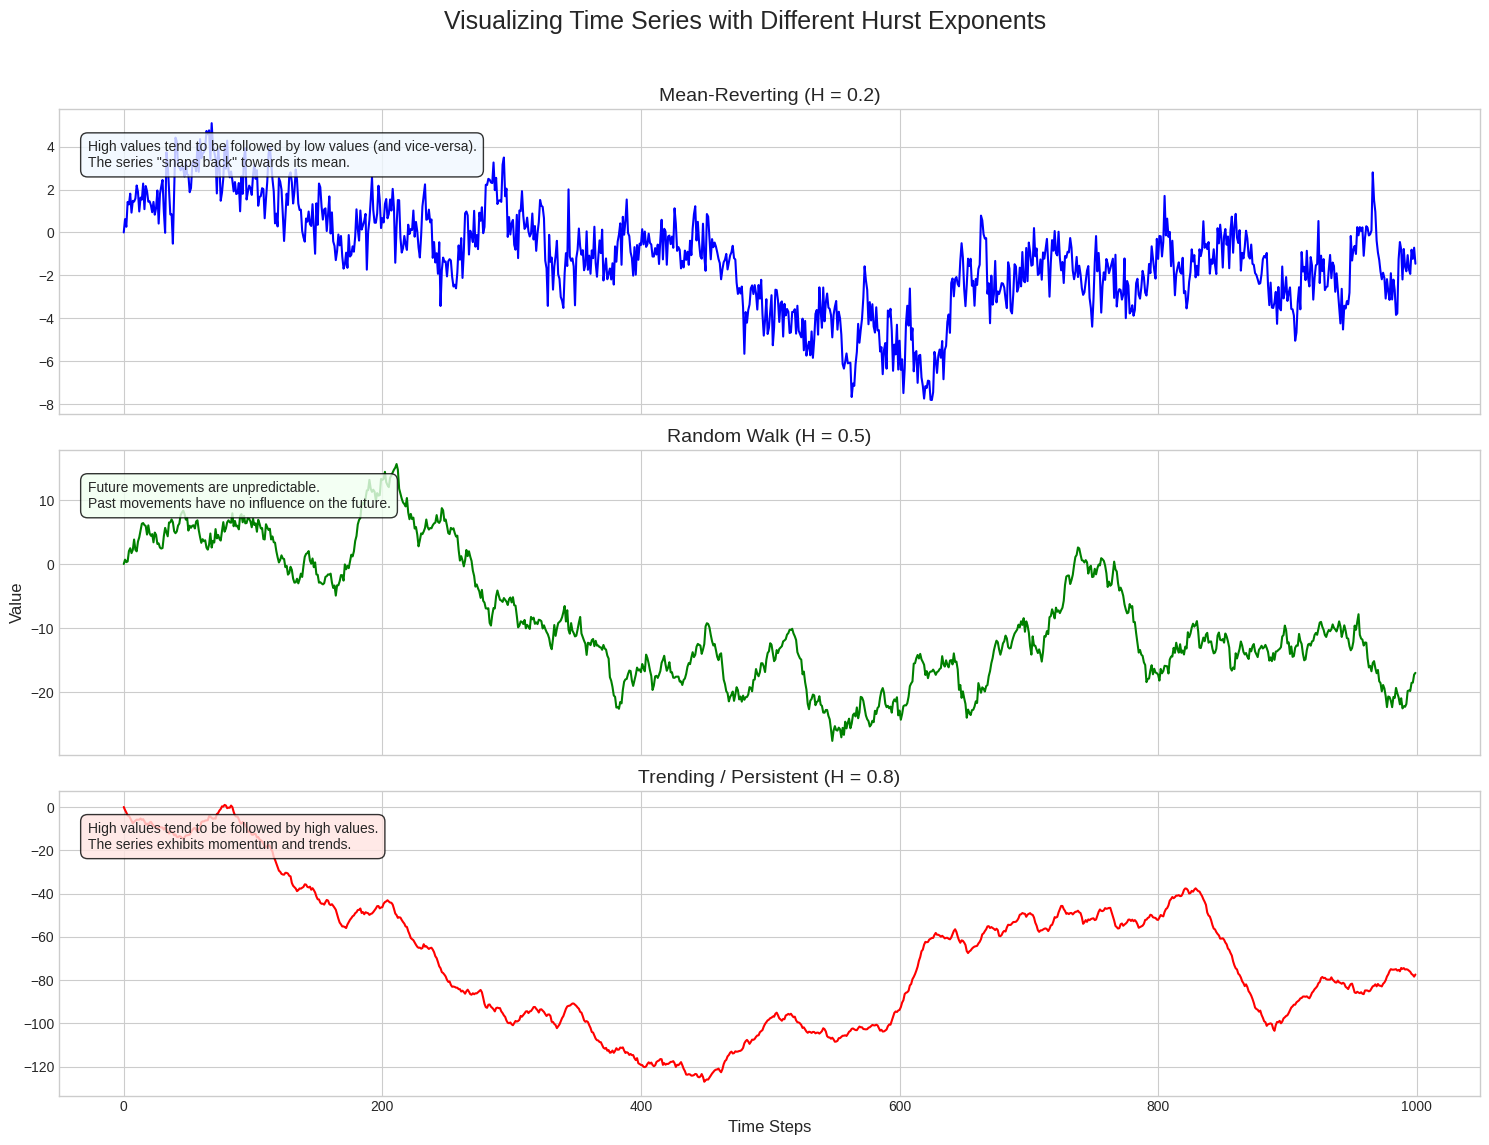

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings("ignore")

def generate_hurst_series(n, H):
    """
    Generates a Fractional Brownian Motion time series with a given Hurst exponent.

    Args:
        n (int): The number of data points to generate.
        H (float): The Hurst exponent (between 0 and 1).

    Returns:
        numpy.ndarray: The generated time series.
    """
    # Generate the increments of the Fractional Gaussian Noise
    gn = np.random.randn(n - 1)

    # Create the covariance matrix for the increments
    C = np.zeros((n - 1, n - 1))
    for i in range(n - 1):
        for j in range(n - 1):
            C[i, j] = 0.5 * (abs(i - j + 1)**(2 * H) - 2 * abs(i - j)**(2 * H) + abs(i - j - 1)**(2 * H))

    # Cholesky decomposition to get the correlated noise
    try:
        L = np.linalg.cholesky(C)
    except np.linalg.LinAlgError:
        # If matrix is not positive-definite, use a fallback (less accurate but stable)
        C += np.eye(n - 1) * 1e-6
        L = np.linalg.cholesky(C)

    fgn = np.dot(L, gn)

    # Integrate the noise to get the Fractional Brownian Motion series
    fbm = np.insert(fgn, 0, 0).cumsum()

    return fbm

# --- Configuration ---
N_POINTS = 1000

# --- Generate Series ---
# Mean-Reverting Series (H < 0.5)
mean_reverting_series = generate_hurst_series(N_POINTS, H=0.2)

# Random Walk Series (H = 0.5)
random_walk_series = generate_hurst_series(N_POINTS, H=0.5)

# Trending (Persistent) Series (H > 0.5)
trending_series = generate_hurst_series(N_POINTS, H=0.8)


# --- Visualization ---
plt.style.use('seaborn-v0_8-whitegrid')
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(15, 12), sharex=True)
fig.suptitle('Visualizing Time Series with Different Hurst Exponents', fontsize=18, y=0.95)

# Plot 1: Mean-Reverting
ax1.plot(mean_reverting_series, color='blue', lw=1.5)
ax1.set_title('Mean-Reverting (H = 0.2)', fontsize=14)
ax1.text(0.02, 0.9, 'High values tend to be followed by low values (and vice-versa).\nThe series "snaps back" towards its mean.',
         transform=ax1.transAxes, verticalalignment='top', bbox=dict(boxstyle='round,pad=0.5', fc='aliceblue', alpha=0.8))

# Plot 2: Random Walk
ax2.plot(random_walk_series, color='green', lw=1.5)
ax2.set_title('Random Walk (H = 0.5)', fontsize=14)
ax2.text(0.02, 0.9, 'Future movements are unpredictable.\nPast movements have no influence on the future.',
         transform=ax2.transAxes, verticalalignment='top', bbox=dict(boxstyle='round,pad=0.5', fc='honeydew', alpha=0.8))
ax2.set_ylabel('Value', fontsize=12)

# Plot 3: Trending
ax3.plot(trending_series, color='red', lw=1.5)
ax3.set_title('Trending / Persistent (H = 0.8)', fontsize=14)
ax3.text(0.02, 0.9, 'High values tend to be followed by high values.\nThe series exhibits momentum and trends.',
         transform=ax3.transAxes, verticalalignment='top', bbox=dict(boxstyle='round,pad=0.5', fc='mistyrose', alpha=0.8))

plt.xlabel('Time Steps', fontsize=12)
plt.tight_layout(rect=[0, 0, 1, 0.93])
plt.show()



Mean reversion for Esabo



--- ESABO Mean Reversion Results ---
Total Trades: 968 | Total PnL: $14275.17 | Sharpe: 1.90
Yearly PnL:
ExitDate
2021-12-31    1627.553105
2022-12-31    6574.338272
2023-12-31    1257.632572
2024-12-31    4311.971522
2025-12-31     503.676722
Freq: YE-DEC, Name: PnL, dtype: float64
Yearly %:
ExitDate
2021-12-31    1.63%
2022-12-31    6.57%
2023-12-31    1.26%
2024-12-31    4.31%
2025-12-31    0.50%
Freq: YE-DEC, Name: PnL, dtype: object
CAGR: 3.05%


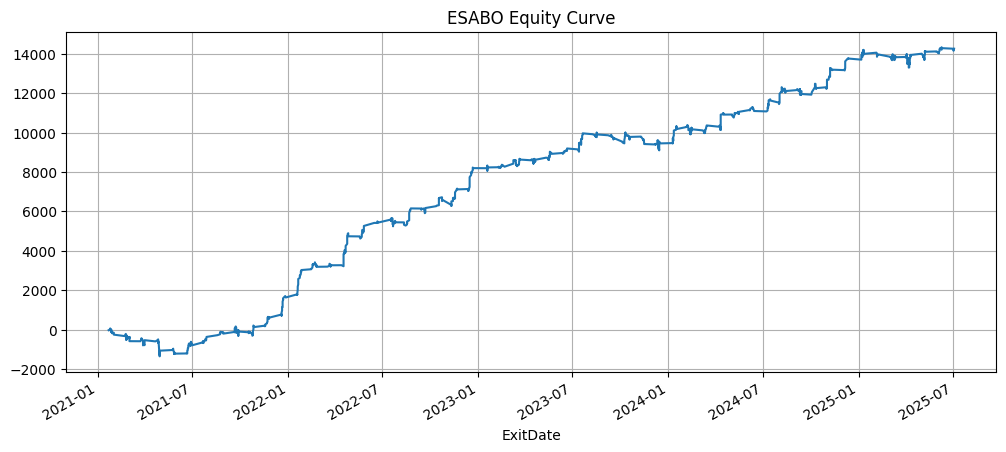

Inverse ESABO Mean Reversion: No trades executed.


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def run_backtest_mean_reversion(
    pairs_over_time,
    price_df,
    trade_period_days,
    lookback=10,
    entry_z=1.5,
    exit_z=0.5,
    stop_loss_z=3.5,
    initial_capital=100000,
    min_score=0.6,
    max_holding_days=10,
    commission_per_trade=0.0005,
    slippage_per_trade=0.0005,
    title_prefix='ESABO'
):
    """
    Backtests a mean-reversion strategy using adaptive Z-score thresholds and score-based capital allocation,
    with lookahead-bias mitigation, realistic cost models, and support for ESABO vs. Inverse ESABO logic.
    """
    is_inverse = title_prefix.lower().startswith('inverse')
    all_trades = []
    date_keys = sorted(pd.to_datetime(list(pairs_over_time.keys())))

    for start_date in date_keys:
        end_date = start_date + pd.DateOffset(days=trade_period_days)
        key_str = start_date.strftime('%Y-%m-%d')
        period_pairs = pairs_over_time.get(key_str)
        if period_pairs is None or period_pairs.empty:
            continue

        # filter by score and compute weights
        period_pairs = period_pairs[period_pairs['Score'] >= min_score].copy()
        if period_pairs.empty:
            continue
        period_pairs['Weight'] = period_pairs['Score'] / period_pairs['Score'].sum()

        data = price_df.loc[start_date:end_date]
        for _, row in period_pairs.iterrows():
            t1, t2, score, weight = row['T1'], row['T2'], row['Score'], row['Weight']
            if t1 not in data or t2 not in data:
                continue
            df = data[[t1, t2]].dropna()
            if len(df) < lookback + 1:
                continue

            # Compute spread and lagged stats
            df['Spread'] = df[t1] - df[t2]
            df['Mean']   = df['Spread'].rolling(lookback, min_periods=lookback).mean().shift(1)
            df['Std']    = df['Spread'].rolling(lookback, min_periods=lookback).std().shift(1)
            df['Z']      = ((df['Spread'] - df['Mean']) / df['Std']).shift(1)

            position = 0
            entry_price = 0
            holding = 0
            for i in range(lookback + 1, len(df)):
                z = df['Z'].iat[i]
                prev_z = df['Z'].iat[i-1]
                spread = df['Spread'].iat[i]
                vol = df['Std'].iat[i]
                date = df.index[i]
                if np.isnan(z) or vol < 0.005:
                    continue

                # adaptive thresholds
                adaptive_entry = entry_z * (1 - 0.5 * (score - min_score) / (1 - min_score))
                adaptive_exit  = exit_z  * (1 - 0.5 * (score - min_score) / (1 - min_score))

                if position == 0:
                    # ESABO: z>entry => short spread; Inverse: z>entry => long spread
                    if z > adaptive_entry and prev_z <= adaptive_entry:
                        position = -1 if not is_inverse else 1
                        entry_price = spread
                        holding = 1
                    elif z < -adaptive_entry and prev_z >= -adaptive_entry:
                        position = 1 if not is_inverse else -1
                        entry_price = spread
                        holding = 1
                else:
                    holding += 1
                    exit_cond = False
                    if position == -1:
                        if z < adaptive_exit or z > stop_loss_z or holding > max_holding_days:
                            raw_pnl = entry_price - spread
                            exit_cond = True
                    else:
                        if z > -adaptive_exit or z < -stop_loss_z or holding > max_holding_days:
                            raw_pnl = spread - entry_price
                            exit_cond = True
                    if exit_cond:
                        cap = initial_capital * weight
                        gross = (raw_pnl / vol) * cap * 0.01
                        cost = 2 * (commission_per_trade + slippage_per_trade) * cap
                        pnl = gross - cost
                        all_trades.append({
                            'ExitDate': date,
                            'PnL': pnl,
                            'Gross': gross,
                            'Cost': cost,
                            'Pair': f"{t1}-{t2}",
                            'Score': score
                        })
                        position = 0
                        holding = 0

    # Compile results
    if not all_trades:
        print(f"{title_prefix} Mean Reversion: No trades executed.")
        return None
    res = pd.DataFrame(all_trades).set_index('ExitDate').sort_index()
    res['Equity'] = res['PnL'].cumsum()

    # Metrics
    daily_ret = res['PnL'].resample('D').sum()
    sharpe = (daily_ret.mean() / daily_ret.std()) * np.sqrt(252) if daily_ret.std() else 0
    yearly = res['PnL'].resample('Y').sum()
    yearly_pct = (yearly / initial_capital).map(lambda x: f"{x:.2%}")
    final_cap = initial_capital + res['Equity'].iloc[-1]
    years = (res.index.max() - res.index.min()).days / 365.25
    cagr = (final_cap/initial_capital)**(1/years) - 1 if years>0 else np.nan

    # Reporting
    print(f"\n--- {title_prefix} Mean Reversion Results ---")
    print(f"Total Trades: {len(res)} | Total PnL: ${res['Equity'].iloc[-1]:.2f} | Sharpe: {sharpe:.2f}")
    print("Yearly PnL:")
    print(yearly)
    print("Yearly %:")
    print(yearly_pct)
    print(f"CAGR: {cagr:.2%}")

    # Plot
    plt.figure(figsize=(12,5))
    res['Equity'].plot(title=f"{title_prefix} Equity Curve", grid=True)
    plt.show()
    return res

# Execute
if 'esabo_pairs_over_time' in locals():
    esabo_results = run_backtest_mean_reversion(
        esabo_pairs_over_time, price_df, TRADE_PERIOD_DAYS,
        title_prefix='ESABO'
    )
if 'inverse_esabo_pairs_over_time' in locals():
    inverse_results = run_backtest_mean_reversion(
        inverse_esabo_pairs_over_time, price_df, TRADE_PERIOD_DAYS,
        title_prefix='Inverse ESABO'
    )
